* ASTER TB image
* MODIS TB image
* GOES TB image
* MODIS-ASTER difference: image & histogram
* GOES-ASTER difference: image & histogram

In [2]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [4]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [5]:
def difference_summary_stats(diff):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    
    # for linear regression stats
    #slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        #'slope' : slope,
        #'intercept' : intercept,
        #'r_value' : r_value,
        #'p_value' : p_value,
        #'std_err' : std_err
        }
    
    return summary_stats_dict

---
Read in the ground based data timeseries for Gaylor Pit and CUES sites

In [6]:
# Gaylor Pit
tuol_df = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
tuol_df['timeUTC'] = tuol_df.index + pd.Timedelta(hours=8)
tuol_df.set_index('timeUTC',inplace=True)
tuol_ds = tuol_df.to_xarray().squeeze()

# CUES
cues_df = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_df['timeUTC'] = cues_df.index + pd.Timedelta(hours=8)
cues_df.set_index('timeUTC',inplace=True)
cues_ds = cues_df.to_xarray().squeeze()

Set up working area geometry

In [7]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets

In [8]:
filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [9]:
ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
ds = ds.rio.clip(geometry)

Open my DEM, reproject to UTM, add to the dataset

In [10]:
dem = xr.open_rasterio('dem/tuolumne_cues_dem.tif').rio.reproject_match(ds)
ds['dem'] = dem

Compute slope and aspect and add to the dataset

In [11]:
dem_array = rd.rdarray(ds.dem.values, no_data=np.nan).squeeze()
slope = rd.TerrainAttribute(dem_array, attrib='slope_riserun')
ds['slope'] = (['y','x'], slope)
aspect = rd.TerrainAttribute(dem_array, attrib='aspect')
ds['aspect'] = (['y','x'], aspect)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Open TCC and ad to the dataset

In [24]:
tcc = xr.open_rasterio('data/NLCD_2016_Tree_Canopy_L48_20190831_2xOlzdukUemPqURl8ckP.tiff').rio.reproject_match(ds)
ds['tcc'] = tcc.squeeze()
ds['fveg'] = (tcc - tcc.min()) / (tcc.max() - tcc.min()) # normalizing tcc to get fveg

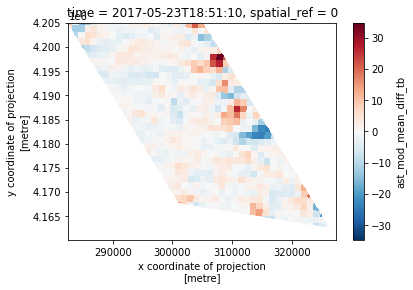

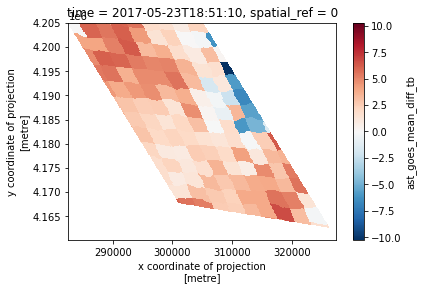

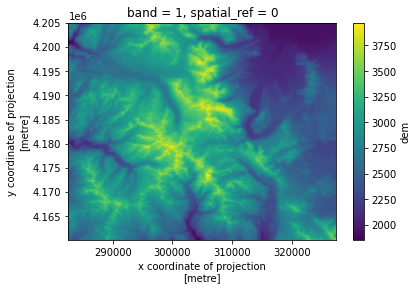

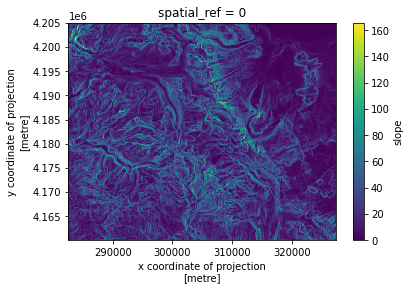

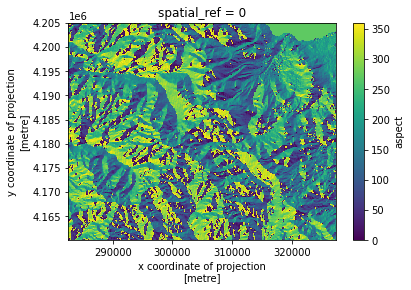

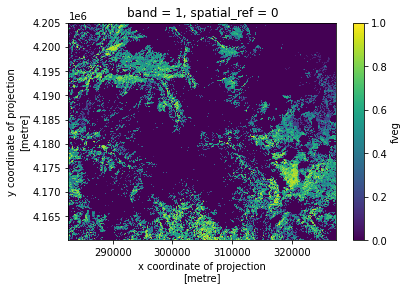

In [25]:
plt.figure()
ds.isel(time=1).ast_mod_mean_diff_tb.plot()

plt.figure()
ds.isel(time=1).ast_goes_mean_diff_tb.plot()

plt.figure()
ds.dem.plot()

plt.figure()
ds.slope.plot()

plt.figure()
ds.aspect.plot()

plt.figure()
ds.fveg.plot()

---
---

Is there a relationship between the brightness temperature differences and Elevation?

Degree difference per KM elevation:  3.17
r-squared:  0.07
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'ABI-ASTER Mean Tb Difference\nWith Elevation')

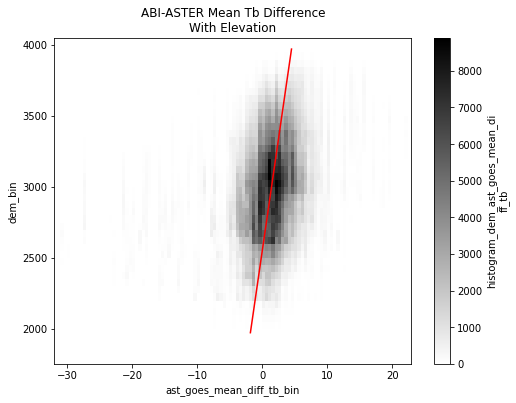

In [12]:
# ABI and ASTER

x = ds.dem
y = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM elevation: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Elevation')

Degree difference per KM elevation:  2.32
r-squared:  0.07
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'MODIS-ASTER Mean Tb Difference\nWith Elevation')

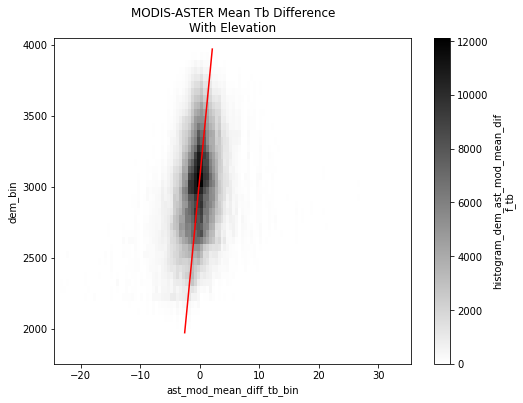

In [13]:
# MODIS and ASTER

x = ds.dem
y = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM elevation: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Elevation')

Is there a relationship between Fveg and the difference in brightness temperatures?

Text(0.5, 1.0, 'Histogram of Fveg\n(zeros removed)')

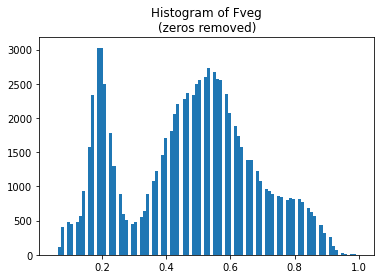

In [87]:
fveg_values = ds.fveg.values.ravel()
fveg_values = fveg_values[fveg_values!=0]
plt.hist(fveg_values,bins=100);
plt.title('Histogram of Fveg\n(zeros removed)')

Degree difference per % fveg:  -0.07
r-squared:  0.0
p-value:  0.0002
standard error:  0.02


Text(0.5, 1.0, 'ABI-ASTER Mean Tb Difference\nWith Fveg')

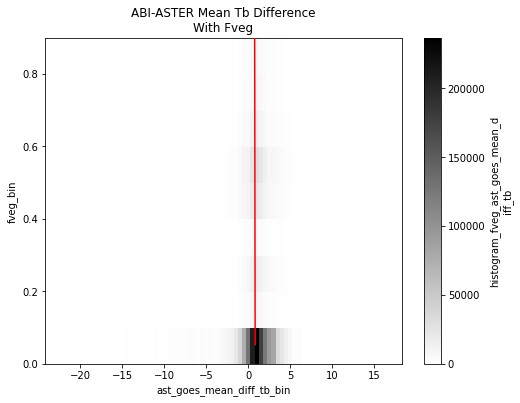

In [74]:
# ABI and ASTER

x = ds.fveg
y = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),0.1)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

## Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)] # remove nans
_y = _y[~np.isnan(_y)]
_y = _y[_x!=0] # remove fveg zeros
_x = _x[_x!=0]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per % fveg: ', np.round(slope,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Fveg')
#plt.xlim(-5,5)

Degree difference per % fveg:  -0.65
r-squared:  0.0
p-value:  0.0
standard error:  0.02


(-5.0, 5.0)

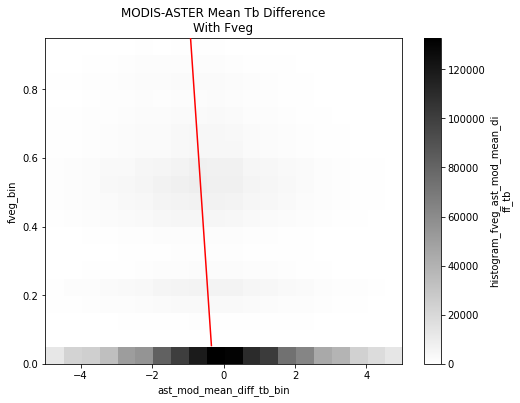

In [78]:
# MODIS and ASTER

x = ds.fveg
y = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),0.05)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

## Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)] # remove nans
_y = _y[~np.isnan(_y)]
_y = _y[_x!=0] # remove fveg zeros
_x = _x[_x!=0]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per % fveg: ', np.round(slope,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Fveg')
plt.xlim(-5,5)

Is there a relationship between E-W or N-S with the difference in brightness temperatures?

Degree difference per KM Easting:  0.0
r-squared:  0.0
p-value:  0.8956
standard error:  0.0


Text(0.5, 1.0, 'ABI-ASTER Mean Tb Difference\nWith Eastings')

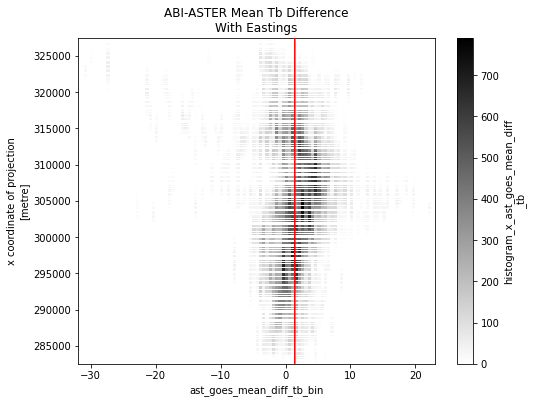

In [14]:
# ABI - ASTER (eastings)

x = ds.x
y = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'y':ds.y.values, 'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM Easting: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Eastings')

Degree difference per KM Northing:  -0.01
r-squared:  0.0
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'ABI-ASTER Mean Tb Difference\nWith Northings')

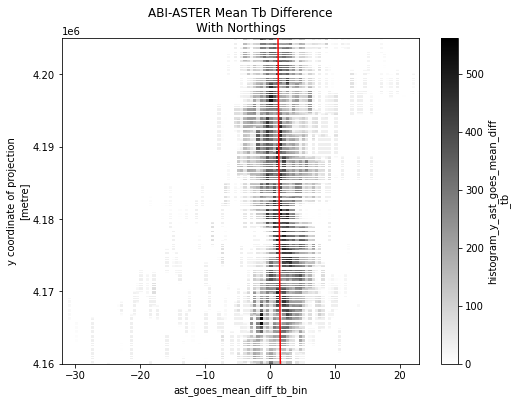

In [15]:
# ABI - ASTER (norhtings)

x = ds.y
y = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'x':ds.x.values, 'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM Northing: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Northings')

Degree difference per KM Easting:  -0.02
r-squared:  0.0
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'MODIS-ASTER Mean Tb Difference\nWith Eastings')

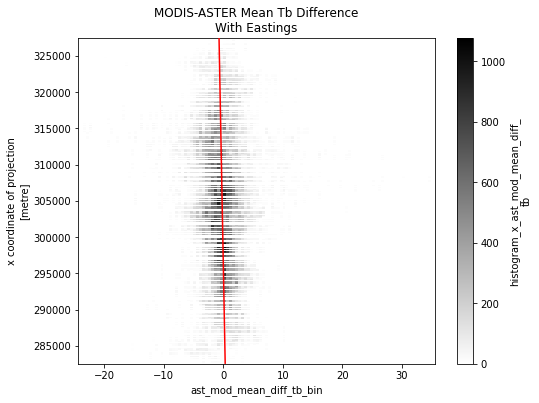

In [16]:
# MODIS - ASTER (eastings)

x = ds.x
y = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'y':ds.y.values, 'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM Easting: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Eastings')

Degree difference per KM Northing:  0.01
r-squared:  0.0
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'MODIS-ASTER Mean Tb Difference\nWith Northings')

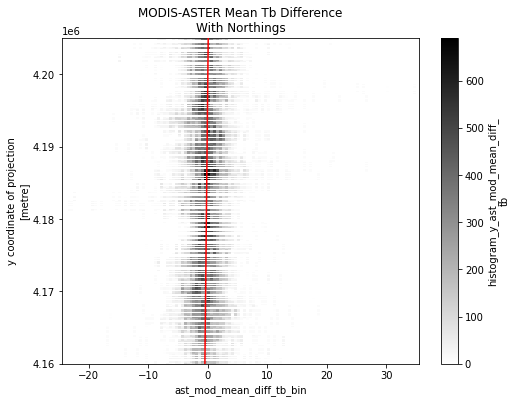

In [17]:
# MODIS - ASTER (norhtings)

x = ds.y
y = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min()-100,x.max()+100,50)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'x':ds.x.values, 'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per KM Northing: ', np.round(slope*1000,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Northings')

Is there a relationship between brightness temperature differences and slope?

Degree difference per rise/run slope:  0.02
r-squared:  0.01
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'ABI-ASTER Mean Tb Difference\nWith Slope')

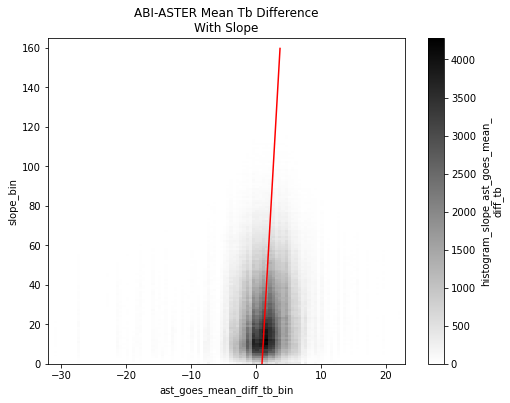

In [18]:
# ABI and ASTER (slope)

x = ds.slope
y = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),1)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per rise/run slope: ', np.round(slope,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Slope')

Degree difference per rise/run slope:  -0.01
r-squared:  0.0
p-value:  0.0
standard error:  0.0


Text(0.5, 1.0, 'MODIS-ASTER Mean Tb Difference\nWith Slope')

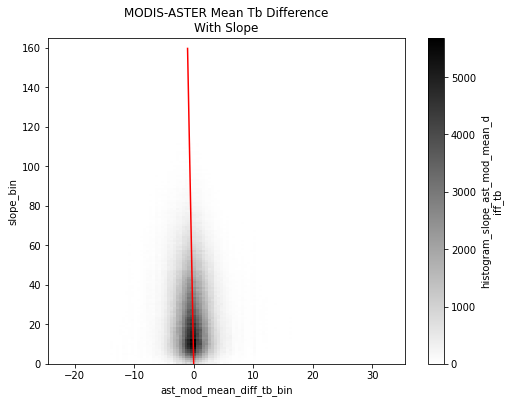

In [19]:
# MODIS and ASTER

x = ds.slope
y = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),1)
ybins = np.arange(y.min()-1,y.max()+1, 0.5)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = y.values.ravel()
_x = _x[~np.isnan(_y)]
_y = _y[~np.isnan(_y)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
print('Degree difference per rise/run slope: ', np.round(slope,2))
print('r-squared: ', np.round(r**2,2))
print('p-value: ', np.round(p,4))
print('standard error: ',np.round(se,2))

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Slope')

Is there a relationship between brightness temperature differences and aspect?

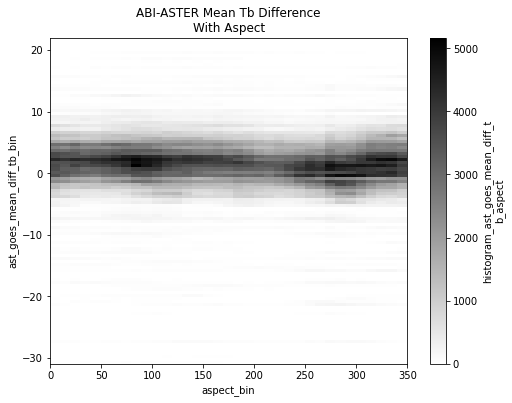

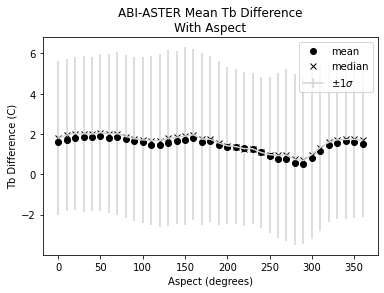

In [24]:
# ABI and ASTER (aspect)

y = ds.aspect
x = ds.ast_goes_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),.5)
ybins = np.arange(y.min(),y.max(), 10)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

# Linear fit
_x = x.values.ravel()
_y = y.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = _y[~np.isnan(_x)]
_x = _x[~np.isnan(_x)]
#slope, intercept, r, p, se = stats.linregress(_x, _y)
#plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
#print('Degree difference per angle azimuth: ', slope)
#print('r-squared: ', r**2)
#print('p-value: ', p)
#print('standard error: ',se)

# format plot
plt.title('ABI-ASTER Mean Tb Difference\nWith Aspect')
#plt.ylim(-10,10)


# Another plot
plt.figure()
_y_rounded = np.round(_y,-1)
_y_bins = np.unique(_y_rounded)
_x_binned_means = [np.mean(_x[_y_rounded==v]) for v in _y_bins]
_x_binned_medians = [np.median(_x[_y_rounded==v]) for v in _y_bins]
_x_binned_stds = [np.std(_x[_y_rounded==v]) for v in _y_bins]

plt.plot(_y_bins,_x_binned_means, linestyle='none', marker='o', c='k', label='mean')
plt.plot(_y_bins,_x_binned_medians, linestyle='none', marker='x', c='k', label='median')
plt.errorbar(_y_bins,_x_binned_medians,yerr=_x_binned_stds, linestyle='-', c='lightgrey', label='$\pm1\sigma$')
plt.title('ABI-ASTER Mean Tb Difference\nWith Aspect')
plt.xlabel('Aspect (degrees)')
plt.ylabel('Tb Difference (C)')
plt.legend()

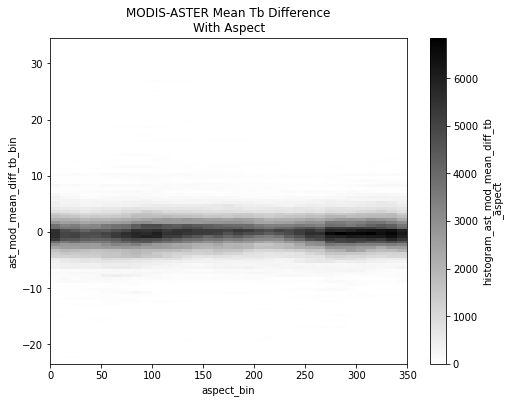

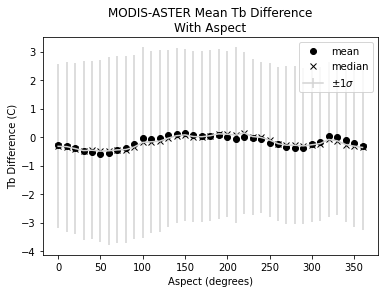

In [25]:
# MODIS and ASTER (aspect)

y = ds.aspect
x = ds.ast_mod_mean_diff_tb

plt.figure(figsize=(8,6))

# Histogram
xbins = np.arange(x.min(),x.max(),.5)
ybins = np.arange(y.min(),y.max(), 10)
histogram(x,
          y, 
          bins=[xbins, ybins],
         ).plot(cmap='binary')

## Linear fit
_x = x.values.ravel()
_y = y.expand_dims(dim={'time':ds.time.values}).values.ravel()
_y = _y[~np.isnan(_x)]
_x = _x[~np.isnan(_x)]
#slope, intercept, r, p, se = stats.linregress(_x, _y)
#plt.plot(slope*np.linspace(_x.min(),_x.max())+intercept,np.linspace(_x.min(),_x.max()), '-r',zorder=99)
#print('Degree difference per angle azimuth: ', slope)
#print('r-squared: ', r**2)
#print('p-value: ', p)
#print('standard error: ',se)

# format plot
plt.title('MODIS-ASTER Mean Tb Difference\nWith Aspect')
#plt.ylim(-10,10)

# Another plot
plt.figure()
_y_rounded = np.round(_y,-1)
_y_bins = np.unique(_y_rounded)
_x_binned_means = [np.mean(_x[_y_rounded==v]) for v in _y_bins]
_x_binned_medians = [np.median(_x[_y_rounded==v]) for v in _y_bins]
_x_binned_stds = [np.std(_x[_y_rounded==v]) for v in _y_bins]

plt.plot(_y_bins,_x_binned_means, linestyle='none', marker='o', c='k', label='mean')
plt.plot(_y_bins,_x_binned_medians, linestyle='none', marker='x', c='k', label='median')
plt.errorbar(_y_bins,_x_binned_medians,yerr=_x_binned_stds, linestyle='-', c='lightgrey', label='$\pm1\sigma$')
plt.title('MODIS-ASTER Mean Tb Difference\nWith Aspect')
plt.xlabel('Aspect (degrees)')
plt.ylabel('Tb Difference (C)')
plt.legend()

---
---

Export timeseries of all values at each of the two study sites.

In [22]:
#gaylor_utm_e = 296649
#gaylor_utm_n = 4195210
#cues_utm_e = 320971
#cues_utm_n = 4168153 
#
#gaylor_timeseries = ds.sel(x=gaylor_utm_e, y=gaylor_utm_n, method='nearest').to_dataframe()
#gaylor_timeseries.to_csv('goes_modis_aster_orthorectified_tb_gaylor_timeseries.csv')
#cues_timeseries = ds.sel(x=cues_utm_e, y=cues_utm_n, method='nearest').to_dataframe()
#cues_timeseries.to_csv('goes_modis_aster_orthorectified_tb_cues_timeseries.csv')

---

### Make plots

In [23]:
#save_figure = True
#
#summary_stats_list = []
#
#for timestep_index in range(len(ds.time)):
#    
#    # Subset dataset to a single time slice
#    _ds = ds.isel(time=timestep_index)
#    
#    ####################################################################################
#    
#    # Get the CUES and Gaylor Pit temperature observations that were taken at the same time as these satellite images
#    print('Looking for {}'.format(ds.time[timestep_index].values))
#    # CUES
#    _cues_ds = cues_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
#    print('Found for CUES: {}'.format(_cues_ds.timeUTC.values))
#    this_cues_tss = _cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].values
#    this_cues_tair = _cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'].values
#    #this_cues_rh = _cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)'].values
#    
#    # Gaylor Pit (Tuolumne)
#    _tuol_ds = tuol_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
#    print('Found for Gaylor Pit: {}'.format(_tuol_ds.timeUTC.values))
#    this_tuol_tss = _tuol_ds.tss.values
#    this_tuol_tair = _tuol_ds.air_temp_c.values    
#       
#    ####################################################################################
#    
#    fig = plt.figure(figsize=(18,25), tight_layout=True)
#    
#    ##### Format figure subplots with subplot2grid:
#    ##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)
#    
#    nrows = 5
#    ncols = 3
#    
#    ax_aster_tb = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
#    ax_modis_tb = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
#    ax_goes_tb = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
#    
#    ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
#    ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
#    blank = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
#    blank.set_axis_off()
#    
#    ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
#    ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
#    blank = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
#    blank.set_axis_off()
#    
#    ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
#    ax_ast_goes_1to1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
#    blank = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
#    blank.set_axis_off()
#        
#    blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
#    blank.set_axis_off()
#    
#    ####################################################################################
#    
#    
#    # make timestamp string for use in figure titles
#    timestamp_str = str(_ds.time.values).split('.')[0]
#    
#    ### Plot the brightness temperature images ###
#    # ASTER Tb
#    _ds.ast_goes_aster_rad2tbK.plot(ax=ax_aster_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
#    ax_aster_tb.set_title('ASTER Band 14\nBrightness Temperature')
#    # MODIS Tb
#    _ds.ast_mod_modis_tb.plot(ax=ax_modis_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
#    ax_modis_tb.set_title('MODIS Band 31\nBrightness Temperature')
#    # GOES Tb
#    _ds.ast_goes_goes_tb.plot(ax=ax_goes_tb, add_colorbar=True, cmap='Greys', vmin=250, vmax=300)
#    ax_goes_tb.set_title('GOES Band 14\nBrightness Temperature')
#
#    ### Plot the difference maps for MODIS-ASTER, and GOES-ASTER ###
#    _ds.ast_mod_mean_diff_tb.plot(ax=ax_ast_mod_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
#    ax_ast_mod_diff.set_title('MODIS - ASTER\nDifference Map')
#    _ds.ast_goes_mean_diff_tb.plot(ax=ax_ast_goes_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
#    ax_ast_goes_diff.set_title('GOES - ASTER\nDifference Map')
#    
#    ### Plot the difference histograms for MODIS-ASTER, and GOES-ASTER ###
#    _ds.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=50, color='k')
#    ax_ast_mod_hist.axvline(_ds.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
#    ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')
#    _ds.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_hist, bins=25, color='k')
#    ax_ast_goes_hist.axvline(_ds.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
#    ax_ast_goes_hist.set_title('GOES - ASTER\nDifference Histogram')
#    # Format the axes limits on the histograms
#    for ax in [ax_ast_mod_hist, ax_ast_goes_hist]:
#        ax.set_xlim(-10,10)
#        #ax.set_ylim()
#    
#    ### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ##
#    # ASTER and MODIS
#    ax_ast_mod_1to1.plot(_ds.ast_mod_mean_rad2tbK, _ds.ast_mod_modis_tb, # aggregated ASTER vs MODIS
#                          linestyle='none', marker='.', color='k', alpha=1)
#    #ax_ast_mod_1to1.plot(_ds.ast_mod_aster_rad2tbK, _ds.ast_mod_modis_tb, # subpixel ASTER vs MODIS
#    #                      linestyle='none', marker='.', color='k', alpha=1)
#    ax_ast_mod_1to1.set_title('Mean ASTER vs MODIS\nBrightness Temperature')
#    ax_ast_mod_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
#    ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')
#    # ASTER and GOES
#    ax_ast_goes_1to1.plot(_ds.ast_goes_mean_rad2tbK, _ds.ast_goes_goes_tb, # aggregated ASTER vs GOES
#                          linestyle='none', marker='.', color='k', alpha=1)
#    #ax_ast_goes_1to1.plot(_ds.ast_goes_aster_rad2tbK, _ds.ast_goes_goes_tb, # subpixel ASTER vs GOES
#    #                      linestyle='none', marker='.', color='k', alpha=1)
#    ax_ast_goes_1to1.set_title('Mean ASTER vs GOES\nBrightness Temperature')
#    ax_ast_goes_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
#    ax_ast_goes_1to1.set_ylabel('GOES $T_B$ [K]')
#    
#    ### Summary Stats ###
#    summary_stats_ast_mod = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
#    summary_stats_ast_subpx_mod = summary_stats(_ds.ast_mod_aster_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
#    summary_stats_ast_goes = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
#    summary_stats_ast_subpx_goes = summary_stats(_ds.ast_goes_aster_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
#    # compile summary stats into a pandas dataframe
#    # Update key names
#    _summary_stats_ast_mod = { 'ast_mod_'+k: v for k, v in summary_stats_ast_mod.items() }
#    _summary_stats_ast_subpx_mod = { 'ast_subpx_mod_'+k: v for k, v in summary_stats_ast_subpx_mod.items() }
#    _summary_stats_ast_goes = { 'ast_goes_'+k: v for k, v in summary_stats_ast_goes.items() }
#    _summary_stats_ast_subpx_goes = { 'ast_subpx_goes_'+k: v for k, v in summary_stats_ast_subpx_goes.items() }
#    # merge all three dictionaries together with some other data values
#    summary_stats_dict = {'time' : _ds.time.values,
#                          'aster_rad_filepath': _ds.attrs['aster_rad_filepath'],
#                          'modis_rad_filepath': _ds.attrs['modis_rad_filepath'],
#                          'goes_rad_filepath': _ds.attrs['goes_rad_filepath'],
#                          'goes_zones_filepath': _ds.attrs['goes_zones_filepath'],
#                          'goes_tb_filepath': _ds.attrs['goes_tb_filepath'],
#                          **_summary_stats_ast_mod, **_summary_stats_ast_subpx_mod,
#                          **_summary_stats_ast_goes, **_summary_stats_ast_subpx_goes}    
#    
#        
#    # append summary stats to list of all summary stats
#    summary_stats_list.append(summary_stats_dict)
#    
#
#    
#    # 1-to-1 plots and axes formatting
#    for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#        # get max and min values for axes
#        (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
#                            int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
#        # add 1-to-1 line
#        ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
#        # set axes limits
#        ax_1_to_1.set_xlim((ax_min,ax_max))
#        ax_1_to_1.set_ylim((ax_min,ax_max))
#    
#    # Add Gaylor Pit and CUES temperatures to 1-to-1 plots, along the 1-to-1 line:
#    for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#        ax_1_to_1.plot(this_cues_tss+273.15, this_cues_tss+273.15, color='tab:blue', linestyle='none', marker='P', markersize=12, label='CUES $T_{ss}$')
#        ax_1_to_1.plot(this_tuol_tss+273.15, this_tuol_tss+273.15, color='tab:blue', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_{ss}$')
#        ax_1_to_1.plot(this_cues_tair+273.15, this_cues_tair+273.15, color='tab:green', linestyle='none', marker='P', markersize=12, label='CUES $T_a$')
#        ax_1_to_1.plot(this_tuol_tair+273.15, this_tuol_tair+273.15, color='tab:green', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_a$')
#        ax_1_to_1.legend()
#        
#    # Plot an outline of the study area, and Gaylor Pit and CUES markers on the map axes
#    for ax in [ax_aster_tb, ax_modis_tb, ax_goes_tb, ax_ast_mod_diff, ax_ast_goes_diff]:
#        ax.set_xlim((utm_e_UL-1000,utm_e_LR+1000))
#        ax.set_ylim((utm_n_LR-1000,utm_n_UL+1000))
#        
#        ax.scatter(296649, 4195210, 
#                            marker='o', 
#                            edgecolor='k', 
#                            facecolor='w', 
#                            s=100, 
#                            label='Gaylor Pit')
#        ax.scatter(320971, 4168153, 
#                            marker='o', 
#                            edgecolor='k', 
#                            facecolor='w', 
#                            s=100, 
#                            label='CUES')
#        ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
#                         [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
#                         linestyle='-', color='k')
#        
#        
#
#    # add title at bottom of figure    
#    fig.suptitle('{}\n{}\n{}\n{}\n{}\n{}'.format(timestamp_str,
#                                         _ds.attrs['aster_rad_filepath'],
#                                         _ds.attrs['modis_rad_filepath'],
#                                         _ds.attrs['goes_rad_filepath'],
#                                         _ds.attrs['goes_zones_filepath'],
#                                         _ds.attrs['goes_tb_filepath']),
#                x=0, y=0.15, ha='left', fontsize=13);
#    
#    filename_friendly_timestamp_str = timestamp_str.replace(':','')
#    if save_figure == True:
#        plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_orthorectified_{}.jpg'.format(filename_friendly_timestamp_str))
#        #plt.savefig('./images/ASTER_MODIS_GOES/upscaled_comparisons/ASTER_MODIS_GOES_original_{}.jpg'.format(filename_friendly_timestamp_str))
#
##### Make pandas dataframe from summary stats dictionaries
#summary_stats_df = pd.DataFrame(summary_stats_list)
## save out to csv file
##summary_stats_df.to_csv('goes_modis_aster_orthorectified_tb_summary_stats.csv')
##summary_stats_df.to_csv('goes_modis_aster_original_tb_summary_stats.csv')